### Implementation of question number 1

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def relu(x):
    return (x > 0) * x

def softmax(x, axis=1):
    e_x = np.exp(x - np.max(x, axis=axis, keepdims=True))
    return e_x / e_x.sum(axis=axis, keepdims=True)

def onehot(y, n_classes):
    o = np.zeros(shape=(y.shape[0], n_classes))
    for i in range(y.shape[0]):
        o[i, int(y[i])] = 1
    return o

In [3]:
class MLP:
    
    def __init__(self, input_size, hidden1_size, hidden2_size, output_size):
        self.W1_range = np.sqrt(6. / (input_size + hidden1_size))
        self.W2_range = np.sqrt(6. / (hidden2_size + hidden1_size))
        self.W3_range = np.sqrt(6. / (output_size + hidden2_size))
        
        self.W1 = np.random.uniform(-self.W1_range, self.W1_range, size=(hidden1_size, input_size))
        #self.W1 = np.random.uniform()
        #self.W1 = np.random.randn()
        self.b1 = np.zeros(hidden1_size)
        
        self.W2 = np.random.uniform(-self.W2_range, self.W2_range, size=(hidden2_size, hidden1_size))
        self.b2 = np.zeros(hidden2_size)
        
        self.W3 = np.random.uniform(-self.W3_range, self.W3_range, size=(output_size, hidden2_size))
        self.b3 = np.zeros(output_size)
        
        print("W1 shape ", self.W1.shape)
        print("b1 shape ", self.b1.shape)
        print("W2 shape ", self.W2.shape)
        print("b2 shape ", self.b2.shape)
        print("W3 shape ", self.W3.shape)
        print("b3 shape ", self.b3.shape)
        
        self.parameters = [self.b1, self.W1, self.b2, self.W2, self.b3, self.W3]
        
    def loop_fprop(self, x):
        ha_1 = np.dot(self.W1, x) + self.b1
        hs_1 = relu(ha_1)
        
        ha_2 = np.dot(self.W2, hs_1) + self.b2
        hs_2 = relu(ha_2)
        
        oa = np.dot(self.W3, hs_2) + self.b3
        os = softmax(oa, axis=0)
        return ha_1, hs_1, ha_2, hs_2, oa, os
        
    def loop_bprop(self, y, x, ha_1, hs_1, ha_2, hs_2, oa, os, weight_decay=0):
        dl_doa = os - y
        
        dl_dW3 = np.outer(dl_doa, hs_2) + weight_decay * self.W3
        dl_db3 = dl_doa
        
        dl_dhs_2 = np.dot(self.W3.T, dl_doa)
        dl_dha_2 = (ha_2 > 0) * dl_dhs_2
        
        dl_dW2 = np.outer(dl_dha_2, hs_1) + weight_decay * self.W2
        dl_db2 = dl_dha_2
        
        dl_dhs_1 = np.dot(self.W2.T, dl_dha_2)
        dl_dha_1 = (ha_1 > 0) * dl_dhs_1
        
        
        dl_dW1 = np.outer(dl_dha_1, x) + weight_decay * self.W1
        dl_db1 = dl_dha_1
        
        return dl_db1, dl_dW1, dl_db2, dl_dW2, dl_db3, dl_dW3
    
    def loop_loss(self, os, y):
        return (y * (-np.log(os))).sum()
    
    def loop_finite_diff(self, x, y, eps=1e-5):
        ha_1, hs_1, ha_2, hs_2, oa, os = self.loop_fprop(x)
        gradients_bprop = self.loop_bprop(y, x, ha_1, hs_1, ha_2, hs_2, oa, os)
        loss = self.loop_loss(os, y)
        gradients_finite_diff = []
        for p in self.parameters:
            grad_fdiff = np.zeros(shape=p.shape)
            for index, v in np.ndenumerate(p):
                p[index] += eps
                _, _, _, _, _, os = self.loop_fprop(x)
                loss_diff = self.loop_loss(os, y)
                grad_fdiff[index] = (loss_diff - loss) / eps
                p[index] -= eps
            gradients_finite_diff.append(grad_fdiff)
        return gradients_finite_diff
    
#     def loop_train(self, data, target, mb_size=100, learning_rate=1e-1, weight_decay=0.):
#         for i in range(data.shape[0] // mb_size):
#             xi = data[i*mb_size:(i+1)*mb_size]
#             yi = target[i*mb_size:(i+1)*mb_size]
#             ha, hs, oa, os = self.mat_fprop(xi)
#             average_loss, average_grads = self.loop_grad(xi, yi, weight_decay)
#             for p, grad in zip(self.parameters, average_grads):
#                 p -= learning_rate * grad
#         return average_loss
    
    def loop_grad(self, x, y, weight_decay=0):
        sum_grads = [np.zeros(shape=p.shape) for p in self.parameters]
        sum_loss = 0
        for xi, yi in zip(x, y):
            ha_1, hs_1, ha_2, hs_2, oa, os = self.loop_fprop(xi)
            grad = self.loop_bprop(yi, xi, ha_1, hs_1, ha_2, hs_2, oa, os, weight_decay)
            sum_grads = [g1 + g2 for g1, g2 in zip(grad, sum_grads)]
            sum_loss += self.loop_loss(os, yi)
        average_grads = [g / x.shape[0] for g in sum_grads]
        return sum_loss / x.shape[0], average_grads
            
#     def loop_predict(self, x):
#         predictions = np.zeros(x.shape[0])
#         for i in range(x.shape[0]):
#             xi = x[i]
#             _, _, _, os = self.loop_fprop(xi)
#             predictions[i] = os.argmax()
#         return predictions
    
    def mat_fprop(self, x):
        #print("inside mat fprop\n")
        #print("x shape ", x.shape)
        #print("W1 shape ", self.W1.shape)
        ha_1 = np.dot(x, self.W1.T) + self.b1
        hs_1 = relu(ha_1)
        
        ha_2 = np.dot(hs_1, self.W2.T) + self.b2
        hs_2 = relu(ha_2)
        
        oa = np.dot(hs_2, self.W3.T) + self.b3
        os = softmax(oa, axis=1)
        return ha_1, hs_1, ha_2, hs_2, oa, os
    
    def mat_bprop(self, y, x, ha_1, hs_1, ha_2, hs_2, oa, os, weight_decay=0):
        bs = x.shape[0]
        dl_doa = os - y
        
        dl_dW3 = np.dot(dl_doa.T, hs_2) / bs + weight_decay * self.W3
        dl_db3 = dl_doa.mean(axis=0)
        
        dl_dhs_2 = np.dot(dl_doa, self.W3)
        dl_dha_2 = (ha_2 > 0) * dl_dhs_2
        
        dl_dW2 = np.dot(dl_dha_2.T, hs_1) / bs + weight_decay * self.W2
        dl_db2 = dl_dha_2.mean(axis=0)
        
        d1_dhs_1 = np.dot(dl_dha_2, self.W2)
        dl_dha_1 = (ha_1 > 0) * d1_dhs_1
        
        dl_dW1 = np.dot(dl_dha_1.T, x) / bs + weight_decay * self.W1
        dl_db1 = dl_dha_1.mean(axis=0)
        
        return dl_db1, dl_dW1, dl_db2, dl_dW2, dl_db3, dl_dW3
    
    def mat_loss(self, os, y):
        return (y * (-np.log(os))).sum(axis=1).mean(axis=0)            
        
    def mat_train(self, data, target, mb_size=100, learning_rate=1e-2, weight_decay=0.):
        for i in range(data.shape[0] // mb_size):
            xi = data[i*mb_size:(i+1)*mb_size]
            yi = target[i*mb_size:(i+1)*mb_size]
            ha_1, hs_1, ha_2, hs_2, oa, os = self.mat_fprop(xi)
            average_grads = self.mat_bprop(yi, xi, ha_1, hs_1, ha_2, hs_2, oa, os, weight_decay)
            average_loss = self.mat_loss(os, yi)
            for p, grad in zip(self.parameters, average_grads):
                p -= learning_rate * grad
        return average_loss
    
    
    def mat_test(self, x, y):
        _, _, _, _, _, os = self.mat_fprop(x)
        return self.mat_loss(os, y), os.argmax(axis=1)

### check that the gradients are correct

In [ ]:
# check the gradient using random sample
mlp = MLP(2, 2, 2, 3)
x = np.random.uniform(-1, 1, size=(2, ))
y = np.zeros(shape=(3, ))
y[1] = 1
ha_1, hs_1, ha_2, hs_2, oa, os = mlp.loop_fprop(x)
print('gradients computed by bprop ', mlp.loop_bprop(y, x, ha_1, hs_1, ha_2, hs_2, oa, os))
print('gradients finite differences', mlp.loop_finite_diff(x, y))

###  Check the gradients

In [ ]:
# check the gradient using random sample
mlp = MLP(2, 2, 2, 3)
x = np.random.uniform(-1, 1, size=(3, 2))
y = np.zeros(shape=(3, 3))
y[0, 1] = 1
y[1, 0] = 1
y[2, 2] = 1
print('gradients computed by bprop ', mlp.loop_grad(x, y)[1])

grad_finitediff = [np.zeros(shape=p.shape) for p in mlp.parameters]
for i in range(3):
    grad_finitediff = [g + g2 / 3 for g, g2 in zip(grad_finitediff, mlp.loop_finite_diff(x[i, :], y[i, :]))]

print('gradients finite differences', grad_finitediff)

### Gradients check

In [ ]:
# check the gradient using random sample
mlp = MLP(2, 2, 3)
x = np.random.uniform(-1, 1, size=(3, 2))
y = np.zeros(shape=(3, 3))
y[0, 1] = 1
y[1, 0] = 1
y[2, 2] = 1
print('gradients computed by loop bprop ', mlp.loop_grad(x, y)[1])

ha, hs, oa, os = mlp.mat_fprop(x)
average_grads = mlp.mat_bprop(y, x, ha, hs, oa, os)
print('gradients computed by mat bprop ', average_grads)

### Loading Fashion MNIST

In [ ]:
# Either put the fashionmnist folder in the current folder or uncomment the next line that will download it
!git clone https://github.com/zalandoresearch/fashion-mnist fashionmnist

In [4]:
from fashionmnist.utils import mnist_reader
from random import shuffle

X_train, y_train = mnist_reader.load_mnist('fashionmnist/data/fashion', kind='train')
X_test, y_test = mnist_reader.load_mnist('fashionmnist/data/fashion', kind='t10k')

indices = list(range(len(X_train)))
shuffle(indices)

X_train = X_train / 255
X_test = X_test / 255

X_valid, y_valid = X_train[indices[55000:]], y_train[indices[55000:]]
X_train, y_train = X_train[indices[:55000]], y_train[indices[:55000]]

y_train_onehot = onehot(y_train, 10)
y_valid_onehot = onehot(y_valid, 10)
y_test_onehot = onehot(y_test, 10)

In [ ]:
print(X_train[0].shape)

### Loading MNIST dataset

In [ ]:
from random import shuffle

mnist_data = np.load('datasets/mnist.npy', encoding='latin1')
X_train, y_train = mnist_data[0]
X_valid, y_valid = mnist_data[1]
X_test, y_test = mnist_data[2]

X_train = X_train.astype("float32")
X_valid = X_valid.astype("float32")
X_test = X_test.astype("float32")

print('len X train ', len(X_train))
print('len y train ', len(y_train))
print('len X valid ', len(X_valid))
print('len y valid ', len(y_valid))
print('len X test ', len(X_test))
print('len y test ', len(y_test))

indices = list(range(len(X_train)))
shuffle(indices)

X_train = X_train / 255
X_valid = X_valid / 255
X_test = X_test / 255

y_train_onehot = onehot(y_train, 10)
y_valid_onehot = onehot(y_valid, 10)
y_test_onehot = onehot(y_test, 10)

In [ ]:
print(X_train[0])
print(y_train_onehot[0])

### Timings matrix vs loop

In [5]:
import time
mlp = MLP(784, 512, 512, 10)
# start_time = time.time()
# mlp.loop_train(X_train, y_train_onehot, mb_size=100)
# time_loop = time.time() - start_time

start_time = time.time()
mlp.mat_train(X_train, y_train_onehot, mb_size=100)
time_mat = time.time() - start_time

#print('Time with loop implementation: %f seconds\n' % time_loop +
# 'Time with mat implementation: %f seconds' % time_mat)
print('Time with mat implementation: %f seconds '%time_mat)

W1 shape  (512, 784)
b1 shape  (512,)
W2 shape  (512, 512)
b2 shape  (512,)
W3 shape  (10, 512)
b3 shape  (10,)
Time with mat implementation: 3.963065 seconds 


### compute train/valid/test loss and accuracy


In [6]:
mlp = MLP(784, 512, 512, 10)

train_accuracies, train_losses = [], []
valid_accuracies, valid_losses = [], []
test_accuracies, test_losses = [], []

for e in range(20):
    loss = mlp.mat_train(X_train, y_train_onehot, mb_size=100)
    
    loss_train, pred_train = mlp.mat_test(X_train, y_train_onehot)
    loss_valid, pred_valid = mlp.mat_test(X_valid, y_valid_onehot)
    loss_test, pred_test = mlp.mat_test(X_test, y_test_onehot)
    valid_losses.append(loss_valid)
    test_losses.append(loss_test)
    #print("pred valid 0 ", pred_valid[1])
    #print("y valid 0 ", y_valid[1])
    valid_accuracies.append((pred_valid == y_valid).mean())
    test_accuracies.append((pred_test == y_test).mean())
    train_losses.append(loss_train)
    train_accuracies.append((pred_train == y_train).mean())

W1 shape  (512, 784)
b1 shape  (512,)
W2 shape  (512, 512)
b2 shape  (512,)
W3 shape  (10, 512)
b3 shape  (10,)


### display training curves



Text(0.5, 0, 'Epochs')

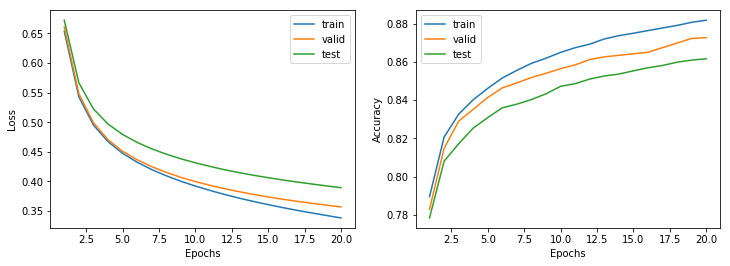

In [7]:
plt.figure(figsize=(12, 4))
axis = plt.subplot(1, 2, 1)
axis.plot(range(1, len(train_losses)+1), train_losses, label='train')
axis.plot(range(1, len(valid_losses)+1), valid_losses, label='valid')
axis.plot(range(1, len(test_losses)+1), test_losses, label='test')
axis.legend()
axis.set_ylabel('Loss')
axis.set_xlabel('Epochs')
axis = plt.subplot(1, 2, 2)
axis.plot(range(1, len(train_accuracies)+1), train_accuracies, label='train')
axis.plot(range(1, len(valid_accuracies)+1), valid_accuracies, label='valid')
axis.plot(range(1, len(test_accuracies)+1), test_accuracies, label='test')
axis.legend()
axis.set_ylabel('Accuracy')
axis.set_xlabel('Epochs')